# Generate Graphs in VIP
We create a graph with each cell as a node, with the connections determined by similarities between the gene expression latent encodings generated by our autoencoder.

In [47]:
# Set up VIP API
from virtualitics import api
import pandas as pd
import networkx as nx

# NOTE: Insert your VIP API token here
vip=api.VIP('')

Setting up WebSocket connection to: ws://localhost:12345/api
Connection Successful! Initializing session.


In [1]:
import numpy as np
from scipy.io import mmread
from scipy import sparse
import os
import pandas as pd
from scipy.io import mmread

data_path = '../data/'

This is a story:
We have 47000 cells. each one of these cells treated with a mixture of signaling molecules that are characteristic of drugs. Once you treat with these drugs single cell RNA sequencing, it spits out what genes are particularly expressed in each cell. The matrix that has cell gene. Each row is a cell. Each column is a gene expression.

In [4]:
# Get autoencoder training data and latent encodings
with open('data/x1.npy', 'rb') as f:
    X1 = np.load(f)
with open('data/x2.npy', 'rb') as f:
    X2 = np.load(f)
with open('data/latent_encodings.npy', 'rb') as f:
    Latent = np.load(f)

In [8]:
cell_types = ['Myeloid', 'T cells', 'B-cells']
drugs =['ALL CYTO', 'DASATINIB_ALL CYTO', 'ALPROSTADIL_ALL CYTO',
        'CYCLOSPORINE_ALL CYTO']

In [9]:
# Generate autoencoder clusters
clusters = []
for cell_type in cell_types:
    for drug in drugs:
        clusters.append(cell_type + ' - ' + drug)

In [10]:
clusters

['Myeloid - ALL CYTO',
 'Myeloid - DASATINIB_ALL CYTO',
 'Myeloid - ALPROSTADIL_ALL CYTO',
 'Myeloid - CYCLOSPORINE_ALL CYTO',
 'T cells - ALL CYTO',
 'T cells - DASATINIB_ALL CYTO',
 'T cells - ALPROSTADIL_ALL CYTO',
 'T cells - CYCLOSPORINE_ALL CYTO',
 'B-cells - ALL CYTO',
 'B-cells - DASATINIB_ALL CYTO',
 'B-cells - ALPROSTADIL_ALL CYTO',
 'B-cells - CYCLOSPORINE_ALL CYTO']

In [14]:
# Test `clusters` indexing
one_hot = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
clusters[np.argmax(one_hot)]

'T cells - CYCLOSPORINE_ALL CYTO'

In [62]:
# Use dot product to compute similarities between cells based on gene expression latent encodings
cell_sim = np.matmul(Latent, Latent.T)
cell_sim.shape

(4983, 4983)

In [63]:
# Take 98th percentile of similarities
thresh = np.percentile(cell_sim, 98)
cell_sim *= (cell_sim >= thresh).astype(int)
np.sum(cell_sim > 0)

496608

In [64]:
# For node attributes
cluster_points = [clusters[np.argmax(one_hot)] for one_hot in X1]
named_gene = pd.DataFrame({'name': list(range(X1.shape[0])), 'cluster': cluster_points})

In [65]:
named_gene_dict = named_gene.T.to_dict()

In [66]:
# Create networkx graph
G_cell = nx.from_numpy_matrix(cell_sim)
nx.set_node_attributes(G_cell, named_gene_dict)

Network data set loaded with name: 'user_dataset_6 (2)'



'user_dataset_6 (2)'

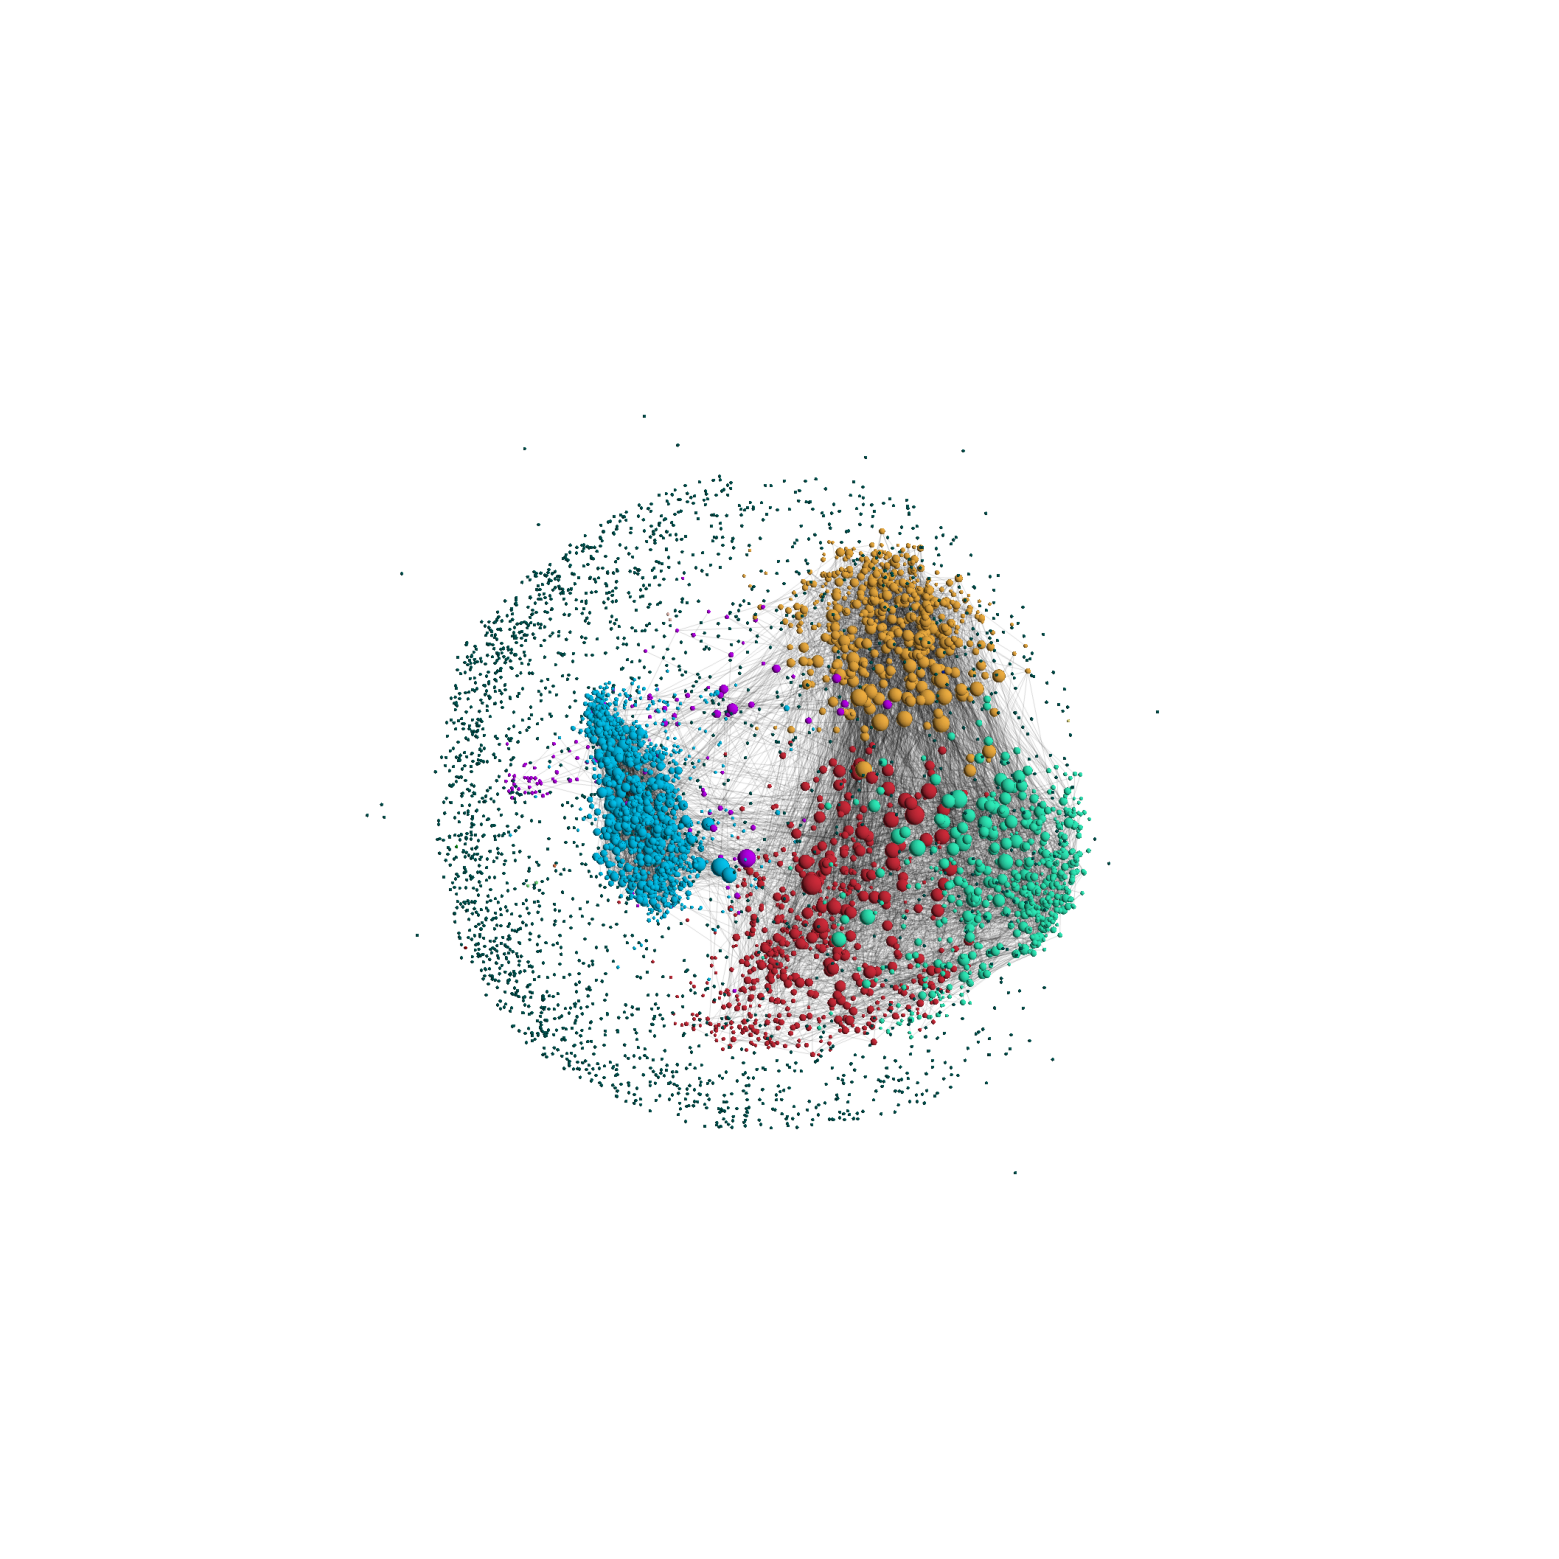

In [69]:
vip.load_network(G_cell)